In [ ]:
!pip install pdpbox
!pip install --upgrade scikit-learn
!pip install git+https://github.com/MaximeJumelle/ALEPython.git@dev#egg=alepython

In [14]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import plot_partial_dependence, partial_dependence
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm
from timeit import default_timer as timer
%load_ext autoreload
%autoreload 2

from pdpbox import pdp, get_dataset, info_plots
from alepython import ale_plot

import os, sys
from contextlib import contextmanager

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
path_to_datasets = "/content/drive/MyDrive/Diary_experiments/datasets/"
random_state = 99

In [4]:
data = pd.read_csv(path_to_datasets + "diabetes.csv")

for ind in range(len(data.dtypes.values)):
  c_type = data.dtypes.values[ind]
  if c_type == np.int64:
    data.iloc[:, ind] = data.iloc[:, ind].astype('int32')
  elif c_type == np.float64:
    data.iloc[:, ind] = data.iloc[:, ind].astype('float32')

In [5]:
@contextmanager
def suppress_stdout():
    with open(os.devnull, "w") as devnull:
        old_stdout = sys.stdout
        sys.stdout = devnull
        try:  
            yield
        finally:
            sys.stdout = old_stdout

#Goal
To check how filter, wrapper, embedded works:
* **to learn about the filter methods** from [here](https://christophm.github.io/interpretable-ml-book/agnostic.html)
* **make an experiment** on how well feature importance is estimated:  
For every feature importance methods:
  1. Calculate importance
  2. Delete/Mask $n$ the least/most informative variables
  3. Calculate score (f1, log-odds) 
  4. Repeat until stopping criteria (min_feature, f1-threshold)

> _NOTE:_  
> - if method doesn't recognize correlated feature we will see sharp rise on a specific iteration






Data was taken from [Diabete Dataset](https://www.kaggle.com/uciml/pima-indians-diabetes-database)

In [5]:
data.sample(10)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
419,3,129,64,29,115,26.4,0.219,28,1
320,4,129,60,12,231,27.5,0.527,31,0
338,9,152,78,34,171,34.2,0.893,33,1
44,7,159,64,0,0,27.4,0.294,40,0
553,1,88,62,24,44,29.9,0.422,23,0
711,5,126,78,27,22,29.6,0.439,40,0
260,3,191,68,15,130,30.9,0.299,34,0
467,0,97,64,36,100,36.8,0.600,25,0
254,12,92,62,7,258,27.6,0.926,44,1
481,0,123,88,37,0,35.2,0.197,29,0


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [6]:
X, y = data.drop(columns=['Outcome']), data['Outcome']
print('Есть дисбаланс классов. Доля "1": ', y.mean())

Есть дисбаланс классов. Доля "1":  0.3489583333333333


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=random_state)

In [8]:
clf = HistGradientBoostingClassifier(max_iter=100, max_depth=5, min_samples_leaf=3, random_state=random_state)
clf.fit(X_train, y_train)
print("F1-score на тесте ", f1_score(y_test, clf.predict(X_test)))

F1-score на тесте  0.6503067484662576


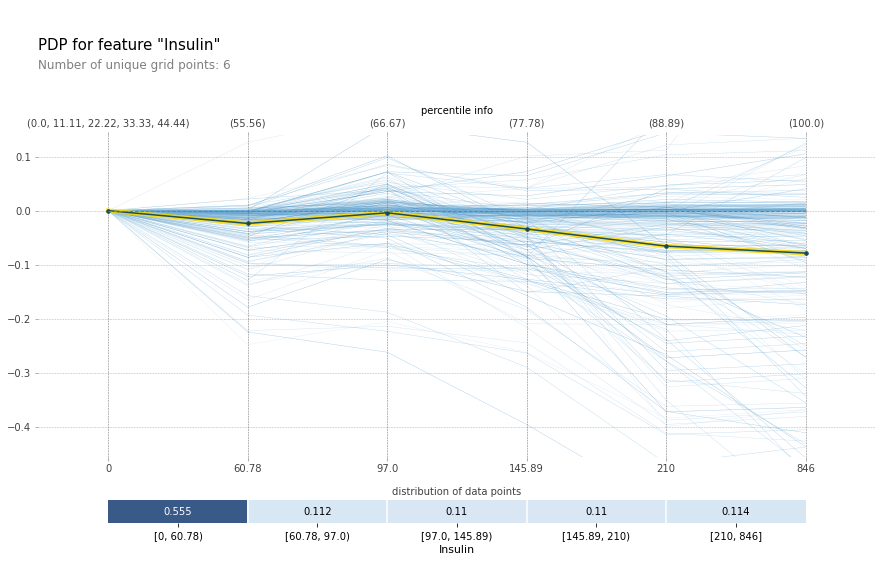

In [26]:
with suppress_stdout():
  pdp_Insulin = pdp.pdp_isolate(
    model=clf, dataset=X_train, model_features=X_train.columns, feature='Insulin'
  )
  fig, axes = pdp.pdp_plot(
    pdp_Insulin, 'Insulin', frac_to_plot=0.5, plot_lines=True, x_quantile=True, show_percentile=True, plot_pts_dist=True
  ) 

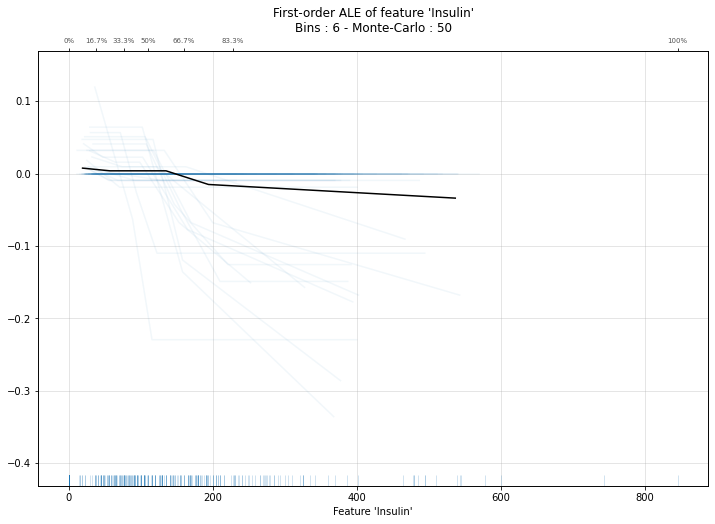

In [11]:
#fig, ax = plt.subplots(figsize=(12, 8))
ale_plot(clf, X_train, 'Insulin', monte_carlo=True)
plt.show()

Pretty the same as PDP + ICE

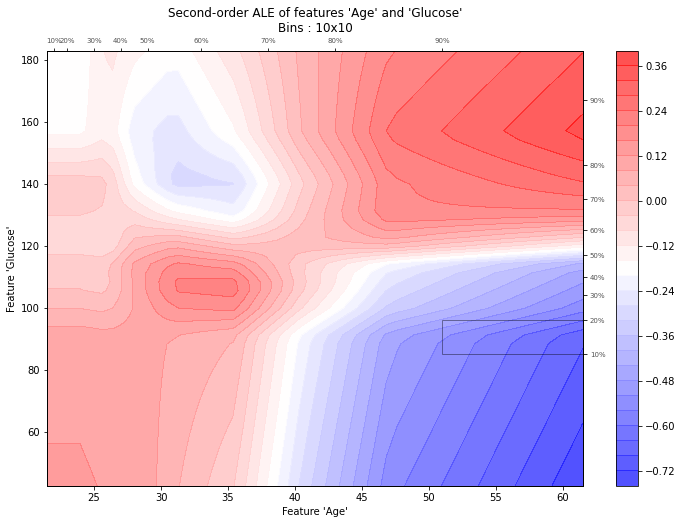

In [12]:
  ale_plot(clf, X_train, ['Age', 'Glucose'], monte_carlo=True)
plt.show()

You can see that in the right area there is a white line, that shows that in a certain age range glucose have determining factor

In [ ]:

def all_feature_interaction(clf, X, n_samples=1000):
    """Finds feature interaction value for each column in X.

    The FI value is the amount of the variance explained by 
    the interaction (difference between observed and no-interaction Partial Dependence)

    Parameters
    ----------
    X : pandas frame
    clf : must have predict and decision function

    Returns
    -------
    H2_all : numpy array
        All feature interaction in the same column order as given in X
    """
    preds = clf.predict(X).reshape(-1, 1)
    pd_one_m = pd_one(clf, X, n_samples)
    pd_all_exc_one_m = pd_all_exc_one(clf, X, n_samples)

    norm_term = np.sum(np.square(preds))

    H2_all = np.sum(np.square(preds - pd_one_m - pd_all_exc_one_m), axis=0) / norm_term

    return H2_all.ravel()


def pd_all_exc_one(clf, X, n_samples=1000):
    """Computes matrix (X.shape[0] x X.shape[1]), where in (i,j) position value 
    is equal to pdp(all_variables_except_j == values in row i)

    Parameters
    ----------
    X : pandas dataframe
    clf : must have predict function
    n_samples : int
        Amount of sampled data to calculate pd

    Returns
    -------
    answer : numpy array of shape (X.shape[0], X.shape[1]) 
    """

    answer = np.empty((X.shape[0], X.shape[1]))
    num_cols = len(X.columns)
    nunique = []
    for col_i in range(num_cols):
        uni = X.iloc[:, col_i].unique()
        if uni.shape[0] > n_samples:
            uni = np.random.choice(uni, n_samples, replace=False)
        nunique.append(uni)

    ind_r = 0
    for row in X.values:
        for i in range(num_cols):
            preds = []
            for uniq in nunique[i]:
                mrow = row
                mrow[i] = uniq
                preds.append(clf.predict(mrow.reshape(1, -1)))
            answer[ind_r, i] = np.array(preds).mean()
        ind_r += 1
    return answer


def pd_one(clf, X, n_samples=1000):
    """Computes matrix (X.shape[0] x X.shape[1]), where in (i,j) position value 
    is equal to pdp(j_variable == value in row i)

    Parameters
    ----------
    X : pandas dataframe
    clf : must have predict function
    n_samples : int
        Amount of sampled data to calculate pd

    Returns
    -------
    answer : numpy array of shape (X.shape[0], X.shape[1]) 
    """
    answer = np.empty((X.shape[0], X.shape[1]))
    num_cols = len(X.columns)
    nunique = []
    for col_i in range(num_cols):
        nunique.append(X.iloc[:, col_i].unique())

    ind_r = 0
    for row in X.values:
        for i in range(num_cols):
            samples_not_i = np.empty((n_samples, num_cols - 1))
            for j in range(num_cols - 1):
                add_ind = 0
                if (j > i):
                    add_ind = 1

                samples_not_i[:, j] = np.random.choice(nunique[j + add_ind], size=n_samples)

            data = np.hstack((samples_not_i[:, :j], np.full((n_samples, 1), row[i]), samples_not_i[:, j:]))
            answer[ind_r, i] = clf.predict(data).mean()
        ind_r += 1
    return answer


In [48]:
start = timer()
f_ints = all_feature_interaction(clf, X_train, n_samples=10000)
end = timer()

time_last = int(end - start)
h = time_last // (60 * 60)
m = (time_last % (60 * 60)) // 60
s = (time_last % (60 * 60)) % 60
print('{0}h {1}min {2}sec'.format(h, m, s))

0h 21min 33sec


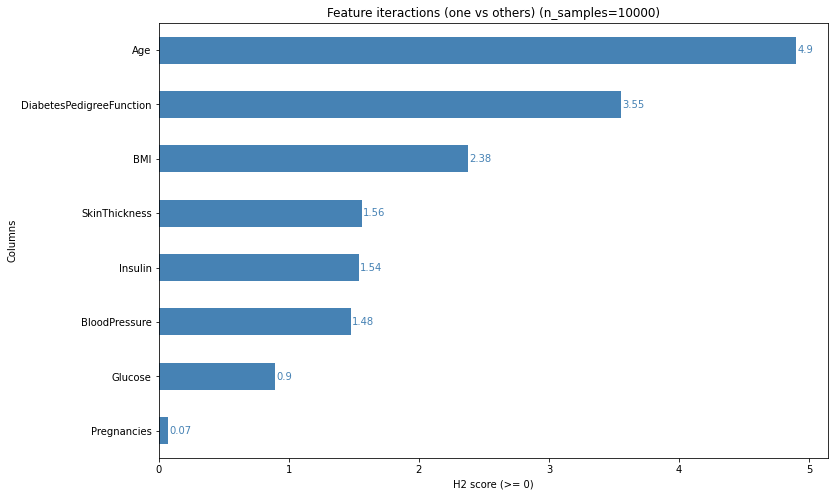

In [49]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)

data = {'columns': X_train.columns, 
              'feature_interaction': f_ints}
data = pd.DataFrame(data,  index=data['columns'])
data.sort_values(by = "feature_interaction").plot(kind = "barh", color = "steelblue", legend = False, grid = True, ax = ax) 
plt.grid(False)
ax.set_title('Feature iteractions (one vs others) (n_samples=10000)')
ax.set_ylabel('Columns')
ax.set_xlabel('H2 score (>= 0)')

for i, v in enumerate(sorted(data.feature_interaction)):
    plt.text(v+0.01, i, str(round(v, 2)), color='steelblue', va="center")

$H_{j}^{2}=\sum_{i=1}^{n}\left[\hat{f}\left(x^{(i)}\right)-P D_{j}\left(x_{j}^{(i)}\right)-P D_{-j}\left(x_{-j}^{(i)}\right)\right]^{2} / \sum_{i=1}^{n} \hat{f}^{2}\left(x^{(i)}\right)$